BASURA QUE CORRE POR DETRÁS

In [1]:
%matplotlib notebook

#Importamos y cargamos el overlay para la FPGA
from pynq import Overlay
base = Overlay("/home/xilinx/jupyter_notebooks/MisCosas/Config/PIDMotorV2.bit")

#Importamos la librería para trabajar con el AXIGPIO
from pynq.lib import AxiGPIO

#Importamos la librería para poder graficar el resultado y otra librería para realizar un delay.
import matplotlib.pyplot as plt
import time

In [2]:
AXIGPIO0=base.ip_dict['axi_gpio_0']
SP=AxiGPIO(AXIGPIO0).channel1
reset=SP[9:10]
RPM=AxiGPIO(AXIGPIO0).channel2

AXIGPIO1=base.ip_dict['axi_gpio_1']
P=AxiGPIO(AXIGPIO1).channel1
ITs=AxiGPIO(AXIGPIO1).channel2

AXIGPIO2=base.ip_dict['axi_gpio_2']
ERROR=AxiGPIO(AXIGPIO2).channel1
CV=AxiGPIO(AXIGPIO2).channel2

In [3]:
def ToBinary(IN, NBits):
    B=[]
    while(IN>1):
        B.append(IN%2)
        IN=IN//2
    B.append(IN)
    while(len(B)<NBits):
        B.append(0)
        
    return B

In [4]:
def ToDecimalBinary(IN, ParteEntera):
    B=[]
    for i in range(0, ParteEntera):
        PM=IN-2**(-i-1)
        if(PM>=0): 
            B.append(1)
            IN=PM
        else: B.append(0)
            
    return B

In [5]:
def ToDecimalEntero(IN):
    DE=0
    for i in range(len(IN)-1, -1, -1):
        DE+=(2**i)*IN[i]
        
    return DE

In [6]:
def InvertBinary(IN):
    B=[]
    for i in range(len(IN)-1, -1, -1):
        B.append(IN[i])
        
    return B

In [7]:
def ComprobarRango(IN, VMax, VMin):
    if IN<=VMax and IN>=VMin:
        return True
    else:
        return False

In [8]:
def CC2(IN, signo):
    if signo:
        IN = ToBinary(IN-1, 1)
        IN = [not IN[i] for i in range(0,len(IN))]
    else:
        IN = ToBinary(IN, 1)
        
    if signo:
        return -1*ToDecimalEntero(IN)
    else:
        return ToDecimalEntero(IN)

In [9]:
def hacerSP(IN, Ts):
    VECTOR=[int(IN[j]*0.3) for j in range(0,len(IN)-1,2) for i in range(0, int((IN[j+1])/Ts))]
    return VECTOR

DATOS

In [10]:
Ts=1 #s

SIN GRÁFICA

In [13]:
Consigna=float(input("RPM: "))
CteP=float(input("P: "))
CteI=float(input("KI: "))

RPM: 500
P: 13
KI: 1


In [14]:
if ComprobarRango(Consigna, 500, 50) and ComprobarRango(CteP, 15.9997, 0) and ComprobarRango(CteI, 1.9999, 0):
    SSPP=int(Consigna*0.3)
    PP=int(ToDecimalEntero(InvertBinary(InvertBinary(ToBinary(CteP//1, 4))+ToDecimalBinary(CteP-CteP//1, 12))))
    PI=int(ToDecimalEntero(InvertBinary(InvertBinary(ToBinary(CteI//1, 1))+ToDecimalBinary(CteI-CteI//1, 15))))

    SP[0:8].write(SSPP)
    P[0:16].write(PP)
    ITs[0:16].write(PI)
else:
    print("CAGASTE")

CON GRÁFICA

In [14]:
CteP=float(input("P: "))
CteI=float(input("KI: "))

P: 12
KI: 1.6


In [15]:
if ComprobarRango(CteP, 15.9997, 0) and ComprobarRango(CteI, 1.9999, 0):
    PP=int(ToDecimalEntero(InvertBinary(InvertBinary(ToBinary(CteP//1, 4))+ToDecimalBinary(CteP-CteP//1, 12))))
    PI=int(ToDecimalEntero(InvertBinary(InvertBinary(ToBinary(CteI//1, 1))+ToDecimalBinary(CteI-CteI//1, 15))))

    P[0:16].write(PP)
    ITs[0:16].write(PI)
else:
    raise ValueError("Fuera de rango")

In [16]:
SSPP=[]

while True:
    Consigna=int(input("Valor SP: "))
    tiempo=int(input("Cuánto tiempo: "))
    
    if not ComprobarRango(Consigna, 500, 50):
        print("CAGASTE")
        continue
    
    SSPP=SSPP+[Consigna, tiempo]
    
    if input("¿Más? y/n: ")=='n':
        break

Valor SP: 500
Cuánto tiempo: 10
¿Más? y/n: y
Valor SP: 450
Cuánto tiempo: 10
¿Más? y/n: y
Valor SP: 475
Cuánto tiempo: 10
¿Más? y/n: y
Valor SP: 500
Cuánto tiempo: 10
¿Más? y/n: n


In [32]:
%%time
i=0
PFF=hacerSP(SSPP, Ts)

t=[]
ProcessValue=[]
ControlValue=[]
SetPoint=[]
Diferencia=[]

SP[0:8].write(PFF[0])
SP[9:10].write(1)

for i in range(0,len(PFF)):
    SP[0:8].write(PFF[i])
    
    t.append(i)
    ProcessValue.append(RPM.read())
    ControlValue.append(CV.read())
    SetPoint.append(PFF[i])
    Diferencia.append(ERROR.read())
    
    time.sleep(Ts)
    
reset.write(0)

CPU times: user 30.3 ms, sys: 9.59 ms, total: 39.9 ms
Wall time: 1min 10s


In [20]:
reset.write(0)

<IPython.core.display.Javascript object>


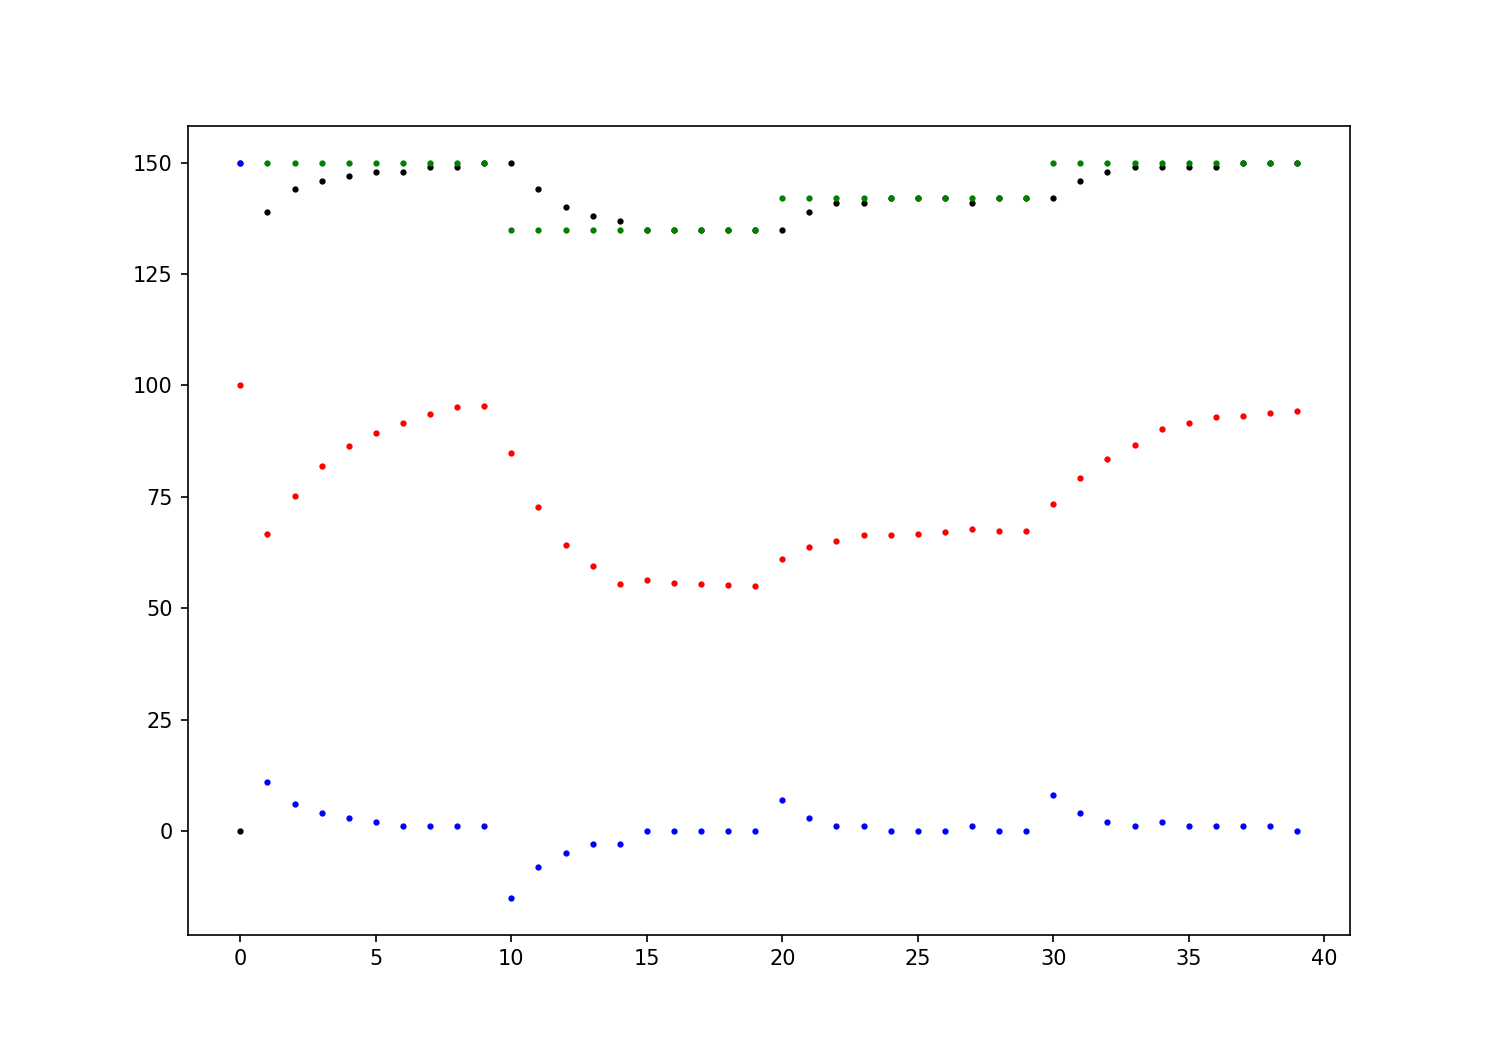

CPU times: user 24.7 s, sys: 810 ms, total: 25.5 s
Wall time: 1min 5s


In [26]:
%%time

PFF=hacerSP(SSPP, Ts)

fig = plt.figure(figsize=[10,7])
ax = fig.add_subplot(111)
fig.show()

SP[0:8].write(PFF[0])
reset.write(1)

for i in range(0,len(PFF)):
    a=time.time()
    SP[0:8].write(PFF[i])

    ax.plot(i,RPM.read(),'ko',markersize=2)
    ax.plot(i,CV.read()/16,'ro',markersize=2)
    ax.plot(i,PFF[i],'go',markersize=2)
    ax.plot(i,CC2(ERROR.read(),ERROR.read()>32767)/128,'bo',markersize=2)
    fig.canvas.draw()

    b=time.time()
    time.sleep(Ts)#-(b-a))

plt.close
reset.write(0)

LAS GRÁFICAS

<IPython.core.display.Javascript object>


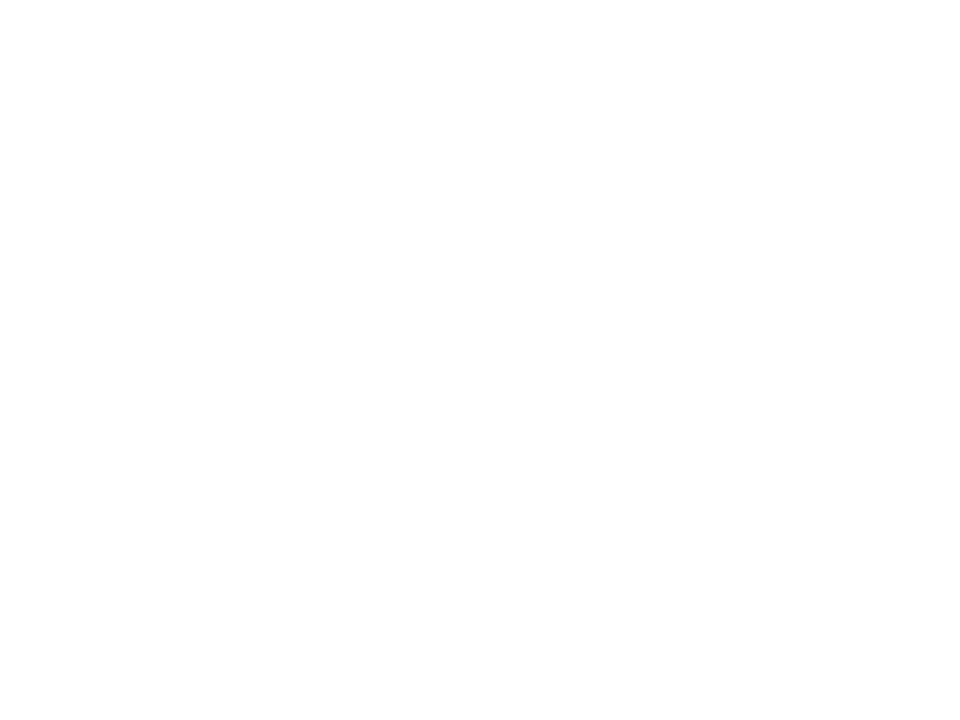

TypeError: 'Figure' object is not iterable

In [17]:
fig, P1 = plt.figure()
P1.plot(ProcessValue, 'g', label='PV');
P1.plot([ControlValue[i]/16 for i in range(0,len(ControlValue))], 'b', label='CV');
P1.plot([SetPoint[i] for i in range(0,len(SetPoint))], 'r', label='SP');
P1.plot([CC2(Diferencia[i], Diferencia[i]>32767)/128 for i in range(0, len(Diferencia))], 'k', label='ERROR');

P1.set_title('Hola')
P1.set_xlabel('Tiempo (ms)')
P1.legend();